In [1]:
import pip

package_names = ['scorecardpy', 'awswrangler', 'sagemaker'] 
pip.main(['install'] + package_names + ['--upgrade'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.2-py3-none-any.whl size=57827 sha256=a89eb180aa9d8f42b0c19bf030fe59ddd05ee1d4e2ed5a323416894eff9a0bce
  Stored in directory: /home/ec2-user/.cache/pip/wheels/21/c0/ae/4c53c5cda995a0ac215e750cbfce536f2bffe401fea3d489a8
  Created wheel for sagemaker: filename=sagemaker-2.59.3.post0-py2.py3-none-any.whl size=618778 sha256=f368f4fcb60aabbfa02ad3b922609a8c893c04379790e8cd81a14e944fbefe2f
  Stored in directory: /home/ec2-user/.cache/pip/wheels/e0/dc/00/a1f1a6255b59a84906cf15fe4c7ac779285fd9ba1cf3ca2f37
Successfully built scorecardpy sagemaker
  Attempting uninstall: idna
    Found existing installation: idna 3.1
    Uninstalling idna-3.1:
      Successfully uninstalled idna-3.1
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.59.3
    Uninstal

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-project 0.9.1 requires ruamel-yaml, which is not installed.
aiobotocore 1.3.0 requires botocore<1.20.50,>=1.20.49, but you have botocore 1.21.44 which is incompatible.


0

In [2]:
# Nativos
from dateutil.relativedelta import relativedelta
from time import gmtime, strftime
from datetime import datetime
import random as rn
import joblib
import json
import sys
import os
import gc

#nube
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker import get_execution_role
import awswrangler as wr
import sagemaker
import boto3

#calculo
import pandas as pd
import numpy as np
import scipy

#grafico
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

#Interacciones con output
import warnings
warnings.filterwarnings("ignore")
# warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

gc.collect()
# MODELS
#from lightgbm import LGBMClassifier

BASE_DIR = os.path.dirname(os.getcwd())
if BASE_DIR not in sys.path: sys.path.append(BASE_DIR)
#import scorecardpy as sc


SEED = 29082013
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

from setup import *

Generating new fontManager, this may take some time...
////////////////////////////////////////////////// 

path_container_input:  /opt/ml/processing/input
path_container_output:  /opt/ml/processing/output
path_container_utils:  /opt/ml/processing/input/utils
path_container_universo:  /opt/ml/processing/input/HM_UNIVERSO_PROPENSION_DESEMBOLSO_BPE
target :::::::::  target_desembolso_f2m_mayor_30_menor_180


### COnfig

In [3]:
print("bucket: ", bucket)
print("region: ", region)
print("now: ", now)
print("target: ", target)

bucket:  sagemaker-us-east-1-058528764918
region:  us-east-1
now:  2021-09-27 13:11:03.190869
target:  target_desembolso_f2m_mayor_30_menor_180


### RUtas

In [4]:
print('uri_output: \n', uri_output)
print("select: \n", select)
print("woe: \n", woe)
print("correlation: \n", correlation)

uri_output: 
 s3://sagemaker-us-east-1-058528764918/vpc/propension/output3
select: 
 s3://sagemaker-us-east-1-058528764918/vpc/propension/output3/seleccion_variables_target_desembolso_f2m_mayor_30_menor_180_clasif_normal.csv
woe: 
 s3://sagemaker-us-east-1-058528764918/vpc/propension/output3/woe_target_desembolso_f2m_mayor_30_menor_180_clasif_normal.json
correlation: 
 s3://sagemaker-us-east-1-058528764918/vpc/propension/output3/train_correlation_clasif_normal.csv


### Correlation

In [5]:
matriz_corr = wr.s3.read_csv(
    correlation, 
    sep=','
)
matriz_corr.index = matriz_corr.columns
matriz_corr.head()

,target_desembolso_f2m_mayor_30_menor_180,flg_registro_ibk,pct_normal,pct_cpp,pct_deficiente,pct_dudoso,pct_perdida,facturacion_periodo_mnt,facturacion_prom_ult3m_mnt,facturacion_prom_ult6m_mnt,facturacion_prom_ult9m_mnt,deuda_agrar_prom_ult3m_mnt,deuda_agrar_prom_ult6m_mnt,deuda_agrar_prom_ult9m_mnt,deuda_sf_prom_ult3m,deuda_sf_prom_ult6m,deuda_sf_prom_ult9m,tend_facturacion_ult_trim_mnt,tend_facturacion_ult_mes_mnt,tend_deuda_agrar_ult_trim_mnt,tend_deuda_agrar_ult_mes_mnt,tend_deuda_sf_ult_trim_mnt,tend_deuda_sf_ult_mes_mnt,nro_entidades_financ_cnt,nro_entid_financ_prom_ult3m_cnt,nro_entid_financ_prom_ult6m_cnt,nro_entid_financ_prom_ult9m_cnt,nro_entid_mayor_actual_ult3m_cnt,nro_entid_diff_actual_ult2m,flg_cambio_banca_ult3m,flg_cambio_banca_ult6m,flg_cambio_banca_ult9m,cambio_banca_ult3m_cnt,cambio_banca_ult6m_cnt,cambio_banca_ult9m_cnt,flg_cambio_region_ult3m,flg_cambio_region_ult6m,flg_cambio_region_ult9m,flg_cambio_segmento_ult3m,flg_cambio_segmento_ult6m,flg_cambio_segmento_ult9m,saldo_reajustado_ult_rcc_amt,max_saldo_reajustado_prom_u3_amt,max_saldo_reajustado_prom_u6_amt,max_saldo_reajustado_prom_u9_amt,sum_saldo_reajustado_prom_u3_amt,sum_saldo_reajustado_prom_u6_amt,sum_saldo_reajustado_prom_u9_amt,nro_entidades_9m_mas_con_saldo_ajust,nro_entidades_8m_mas_con_saldo_ajust,nro_entidades_7m_mas_con_saldo_ajust,nro_entidades_6m_mas_con_saldo_ajust,nro_entidades_5m_mas_con_saldo_ajust,nro_entidades_4m_mas_con_saldo_ajust,nro_entidades_3m_mas_con_saldo_ajust,nro_entidades_2m_mas_con_saldo_ajust,nro_entidades_1m_mas_con_saldo_ajust,nro_entidades_no_tiene_saldo_ajust_u9,nro_entidades_no_tiene_saldo_ajust_u6,nro_entidades_no_tiene_saldo_ajust_u3,nro_entidades_termino_prest_u9,nro_entidades_termino_prest_u6,nro_entidades_termino_prest_u3,nro_entid_recien_3m_con_saldoajust_u9,nro_entid_recien_2m_con_saldoajust_u9,nro_entid_recien_1m_con_saldoajust_u9,nro_entid_recien_3m_con_saldoajust_u6,nro_entid_recien_2m_con_saldoajust_u6,nro_entid_recien_1m_con_saldoajust_u6,ult_var_saldo_ajustado_amt,var_neta_saldo_ajustado_u3_amt,var_neta_saldo_ajustado_u6_amt,monto_adquirido_ult_rcc_amt,monto_adquirido_u3_amt,monto_adquirido_u6_amt,monto_pagado_ult_rcc_amt,monto_pagado_u3_amt,monto_pagado_u6_amt,target_desembolso_f2m_mayor_10_menor_180,target_monto_variacion_f1m,target_monto_variacion_f2m,nro_var_10k_30k_positiva_ult_rcc,nro_var_10k_30k_positiva_u3,nro_var_10k_30k_positiva_u6,nro_var_10k_30k_negativa_ult_rcc,nro_var_10k_30k_negativa_u3,nro_var_10k_30k_negativa_u6,nro_var_up180k_positiva_ult_rcc,nro_var_up180k_positiva_u3,nro_var_up180k_positiva_u6,nro_var_up180k_negativa_ult_rcc,nro_var_up180k_negativa_u3,nro_var_up180k_negativa_u6,saldo_coloc_vig_amt,saldo_coloc_vig_ibk_amt,saldo_coloc_vig_otros_bancos_amt,saldo_coloc_vig_cajas_amt,sow_ibk,sow_otros_bancos,sow_cajas,nro_tipo_entidad,nro_entidades,nroregs_garantia_reactiva_bcos,nroregs_reactiva_bcos,nroregs_inmobiliario_bcos,nroregs_garantias_bcos,nroregs_reprogramados_bcos,nroregs_cred_castigados_bcos,nroregs_garantia_fae_bcos,nroregs_fae_bcos,nroregs_coloc_directas_bcos,nroregs_coloc_indirectas_bcos,nroregs_garantia_reactiva_cajas,nroregs_reactiva_cajas,nroregs_inmobiliario_cajas,nroregs_garantias_cajas,nroregs_reprogramados_cajas,nroregs_cred_castigados_cajas,nroregs_garantia_fae_cajas,nroregs_fae_cajas,nroregs_coloc_directas_cajas,nroregs_coloc_indirectas_cajas,flg_clasif_normal,flg_clasif_cpp,flg_clasif_deficiente,flg_clasif_dudosa,flg_clasif_perdida,saldo_vig_con_lm,saldo_vig_sin_lm,saldo_venc_con_lm,saldo_venc_sin_lm,saldo_garantia_reactiva,saldo_reactiva,saldo_inmobiliario,saldo_garantias,saldo_reprogramados,saldo_creditos_castigados,saldo_garantia_fae,saldo_fae,saldo_coloc_directas,saldo_coloc_indirectas,saldo_coloc_direct_vig_bcos,saldo_coloc_direct_vig_cmpt,saldo_coloc_direct_vig_no_ibk,saldo_coloc_direct_vig_ibk,saldo_coloc_direct_vig_cajas,porc_coloc_direct_vig_bcos,porc_coloc_direct_vig_cmpt,porc_coloc_direct_vig_no_ibk,porc_coloc_direct_vig_ibk,porc_coloc_direct_vig_caja

In [6]:
top_correlacion = pd.DataFrame(matriz_corr[target].abs().sort_values(ascending=False))
top_correlacion.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target_desembolso_f2m_mayor_30_menor_180
target_desembolso_f2m_mayor_30_menor_180,1.00000
target_desembolso_f2m_mayor_10_menor_180,0.70452
target_monto_variacion_f2m,0.29341
nro_entidades_no_tiene_saldo_ajust_u9,0.09683
nro_entidades_no_tiene_saldo_ajust_u6,0.09637
nro_entidades_no_tiene_saldo_ajust_u3,0.09486
monto_pagado_u3_amt,0.08292
monto_pagado_u6_amt,0.08115
monto_pagado_ult_rcc_amt,0.07911
deuda_sf_prom_ult9m,0.07690


In [7]:
dict_correlation = top_correlacion.iloc[:].to_dict()[target]

### Selección iv / probabilidad

In [8]:
seleccion = wr.s3.read_csv(
    select, 
    sep=','
)
seleccion.head(20)

,ranking_iv,ranking_prob,variable,max_prob,iv,woe
0,0,8,ult_var_saldo_ajustado_amt,0.074334,0.329083,1.049412
1,1,6,monto_pagado_u3_amt,0.081903,0.319598,1.154592
2,2,4,monto_pagado_u6_amt,0.084874,0.305394,1.193466
3,3,0,nro_entidades_no_tiene_saldo_ajust_u9,0.120596,0.296464,1.584555
4,4,1,nro_entidades_no_tiene_saldo_ajust_u6,0.115972,0.295236,1.540220
5,5,2,nro_entidades_no_tiene_saldo_ajust_u3,0.102411,0.294729,1.400643
6,6,9,monto_pagado_ult_rcc_amt,0.074021,0.288472,1.044854
7,7,22,var_neta_saldo_ajustado_u3_amt,0.062159,0.260366,0.857465
8,8,83,deuda_sf_prom_ult9m,0.047195,0.229432,0.566242
9,9,84,deuda_agrar_prom_ult9m_mnt,0.047183,0.229325,0.565962


In [9]:
seleccion['correlation_spearman'] = seleccion['variable'].apply(lambda _: dict_correlation.get(_, 100))
seleccion = seleccion.sort_values(
    by=['correlation_spearman'], ascending=False).reset_index(drop=True).reset_index().rename(columns={'index': 'ranking_corr'})

seleccion['ranking'] = seleccion[['ranking_prob', 'ranking_iv', 'ranking_corr']].mean(axis=1)
seleccion = seleccion.sort_values(by=['ranking'], ascending=True).reset_index(drop=True)

seleccion.head(30)

,ranking_corr,ranking_iv,ranking_prob,variable,max_prob,iv,woe,correlation_spearman,ranking
0,2,3,0,nro_entidades_no_tiene_saldo_ajust_u9,0.120596,0.296464,1.584555,0.096829,1.666667
1,3,4,1,nro_entidades_no_tiene_saldo_ajust_u6,0.115972,0.295236,1.540220,0.096374,2.666667
2,4,5,2,nro_entidades_no_tiene_saldo_ajust_u3,0.102411,0.294729,1.400643,0.094864,3.666667
3,5,1,6,monto_pagado_u3_amt,0.081903,0.319598,1.154592,0.082917,4.000000
4,6,2,4,monto_pagado_u6_amt,0.084874,0.305394,1.193466,0.081153,4.000000
5,7,6,9,monto_pagado_ult_rcc_amt,0.074021,0.288472,1.044854,0.079110,7.333333
6,26,0,8,ult_var_saldo_ajustado_amt,0.074334,0.329083,1.049412,0.057355,11.333333
7,27,32,10,nro_entidades,0.072276,0.111146,1.019119,0.055955,23.000000
8,53,13,7,var_neta_saldo_ajustado_u6_amt,0.078527,0.158131,1.108832,0.030941,24.333333
9,14,15,45,sum_saldo_reajustado_prom_u9_amt,0.051533,0.155271,0.658730,0.064095,24.666667


In [10]:
def corr_detail(df_corr, min_value=0.85, show_detail=True, col_target='target'):
    
    corr_taret = df_corr[col_target].sort_values(ascending=False).apply(lambda _: abs(_)).sort_values(ascending=False)
    
    from itertools import combinations
    def add_dicc(key, val, num, dicc):
        if key in dicc:
            dicc[key].append((val, num))
        else:
            dicc[key] = [(val, num)]
        
    set_unique, list_detected = set(), []
    dicc_detected = {}
    

    for cols in combinations(list(df_corr.columns), 2):
        corr_columns = np.fabs(df_corr[cols[0]][cols[1]])
        
        if corr_columns >= min_value:
            set_unique.update(cols)
            list_detected.extend(list(cols))
            add_dicc(cols[0], cols[1], corr_columns, dicc_detected)
            add_dicc(cols[1], cols[0], corr_columns, dicc_detected)        
            
    print("ANALISIS CORRELACION ENTRE COLUMNAS :")
    columnas_aparece = []
    cols_del = []
    for colc, cant in sorted(
        [(col, list_detected.count(col)) for col in set_unique], key=lambda _: _[1], reverse=True):
        
        if colc not in columnas_aparece:
            print("/"*30)
            print("-> ", colc, ' :::: ',cant, ' ///// ', corr_taret[colc])
            columnas_aparece.append(colc)
            if show_detail:
                for _ in dicc_detected[colc]:
                    print(" "*10, *_, '///// ',  corr_taret[_[0]])
                    #columnas_aparece.append(_[0])
                    
                    if corr_taret[_[0]] <= corr_taret[colc]:
                        cols_del.append(_[0])
                    else:
                        cols_del.append(colc)
                    
    del dicc_detected
    del list_detected
    del set_unique
    return list(set(cols_del))

In [11]:
top_30 = list(seleccion.head(150)['variable'])

In [12]:
corr = matriz_corr.reset_index()
corr = corr[corr['index'].isin(top_30)]
corr = corr[['index', target] + top_30].set_index('index')
corr.shape

(150, 151)

In [13]:
#corr

In [14]:
list_del = corr_detail(corr, min_value=0.875, show_detail=True, col_target=target)
len(list_del)

ANALISIS CORRELACION ENTRE COLUMNAS :
//////////////////////////////
->  tendencia_saldo_coloc_direct_vig_ibk  ::::  11  /////  0.02587719982374261
           prom_coloc_direct_ibk_u12m 0.9269207759250272 /////  0.028386838725799068
           prom_coloc_direct_ibk_u6m 0.9780787214755188 /////  0.02704688985445147
           tendencia_saldo_coloc_direct_vig_ibk_6m_v2 0.9335373381339704 /////  0.028413200493336482
           meses_con_coloc_direct_ibk_u12m_cnt 0.927602105498652 /////  0.028263421909207026
           prom_coloc_direct_ibk_u3m 0.999906101126935 /////  0.026139754699048442
           saldo_coloc_direct_vig_ibk 0.9811476038046518 /////  0.02520498869866487
           tendencia_saldo_coloc_direct_vig_ibk_v2 0.9652470672461504 /////  0.026982300670593498
           meses_con_coloc_direct_ibk_u6m_cnt 0.9782738158971656 /////  0.0269282935621642
           saldo_coloc_vig_ibk_amt 0.975087274692954 /////  0.0249028501185615
           porc_coloc_direct_vig_ibk 0.9809243749692766

85

In [15]:
seleccionadas = [col for col in top_30 if col not in list_del]
print(seleccionadas)

['nro_entidades_no_tiene_saldo_ajust_u9', 'monto_pagado_u3_amt', 'monto_pagado_ult_rcc_amt', 'ult_var_saldo_ajustado_amt', 'nro_entidades', 'nro_var_10k_30k_negativa_u6', 'sum_saldo_reajustado_prom_u3_amt', 'nro_var_10k_30k_negativa_u3', 'monto_adquirido_u6_amt', 'nroregs_coloc_directas_bcos', 'deuda_sf_prom_ult9m', 'nro_entid_financ_prom_ult9m_cnt', 'saldo_coloc_direct_vig_cmpt', 'saldo_coloc_direct_tc', 'nro_var_10k_30k_negativa_ult_rcc', 'saldo_coloc_direct_vig_bcos', 'nro_entidades_financ_cnt', 'nro_entidades_1m_mas_con_saldo_ajust', 'nro_entidades_2m_mas_con_saldo_ajust', 'monto_adquirido_u3_amt', 'nroregs_reprogramados_bcos', 'tendencia_nro_coloc_direct_bancos_v2', 'nro_entidades_3m_mas_con_saldo_ajust', 'prom_reprog_u12m', 'nroregs_garantias_bcos', 'prom_fae_u12m', 'tendencia_saldo_coloc_direct_vig_ibk_6m_v2', 'tend_deuda_agrar_ult_mes_mnt', 'tend_deuda_agrar_ult_trim_mnt', 'nro_entidades_4m_mas_con_saldo_ajust', 'nro_entidades_6m_mas_con_saldo_ajust', 'prom_saldo_vig_lm_u12m', 

In [16]:
len(seleccionadas)

65

### Seleccionadas

In [17]:
seleccion[seleccion['variable'].isin(seleccionadas)].reset_index(drop=True)

,ranking_corr,ranking_iv,ranking_prob,variable,max_prob,iv,woe,correlation_spearman,ranking
0,2,3,0,nro_entidades_no_tiene_saldo_ajust_u9,0.120596,0.296464,1.584555,0.096829,1.666667
1,5,1,6,monto_pagado_u3_amt,0.081903,0.319598,1.154592,0.082917,4.000000
2,7,6,9,monto_pagado_ult_rcc_amt,0.074021,0.288472,1.044854,0.079110,7.333333
3,26,0,8,ult_var_saldo_ajustado_amt,0.074334,0.329083,1.049412,0.057355,11.333333
4,27,32,10,nro_entidades,0.072276,0.111146,1.019119,0.055955,23.000000
5,28,46,5,nro_var_10k_30k_negativa_u6,0.084389,0.082560,1.187205,0.054254,26.333333
6,12,12,55,sum_saldo_reajustado_prom_u3_amt,0.050377,0.161594,0.634822,0.064855,26.333333
7,34,49,3,nro_var_10k_30k_negativa_u3,0.085687,0.068097,1.203885,0.050500,28.666667
8,22,22,52,monto_adquirido_u6_amt,0.050554,0.140933,0.638519,0.058973,32.000000
9,46,42,11,nroregs_coloc_directas_bcos,0.071409,0.093525,1.006112,0.041419,33.000000


### WOE BIN

In [18]:
woe_df = pd.read_json(woe)
woe_df.head()

,maxdias_atraso_sobreg_avance,tendencia_reprogramados,sum_saldo_reajustado_prom_u9_amt,prom_fae_u3m,tendencia_cobertura_gar_pref_over_coloc_direct_vig_venc,tendencia_saldo_comex,nroregs_reactiva_cajas,prom_inmobiliario_u12m,tend_deuda_agrar_ult_mes_mnt,max_saldo_reajustado_prom_u9_amt,nro_entid_recien_1m_con_saldoajust_u6,max_saldo_reajustado_prom_u3_amt,prom_inmobiliario_u6m,nro_tipo_entidad,saldo_coloc_directas,nroregs_cred_castigados_bcos,ciiu_cd_encoder_target_desembolso_f2m_mayor_30_menor_180,monto_adquirido_u6_amt,saldo_coloc_vig_amt,tendencia_garantias_v2,nro_var_10k_30k_negativa_u3,cobert_garpref_over_coloc_direct,nro_var_10k_30k_positiva_u6,monto_adquirido_ult_rcc_amt,tendencia_factoring,meses_con_coloc_direct_cajas_u12m_cnt,tendencia_saldo_vig_lm_6m_v2,region_fin_val_LIMA,maxdias_atraso_factoring,maxdias_atraso_leasing,meses_con_gar_u12m_cnt,meses_con_saldo_vig_lm_u12m_cnt,maxdias_atraso_reprog,nro_entid_financ_prom_ult6m_cnt,nroregs_fae_bcos,meses_con_coloc_direct_venc_u6m_cnt,nro_entid_recien_2m_con_saldoajust_u6,saldo_garant_autoliquid,percent_tc,nro_var_up180k_negativa_ult_rcc,monto_pagado_u3_amt,tendencia_saldo_coloc_direct_vig_ibk_v2,prom_saldo_vig_lm_u12m,flg_clasif_cpp,saldo_creditos_castigados,saldo_coloc_direct_vig_cajas,nro_entidades_no_tiene_saldo_ajust_u3,prom_atraso_coloc_direct_vig_u6m,saldo_coloc_vig_ibk_amt,saldo_coloc_direct_factoring,nroregs_garantias_bcos,maxdias_atraso_coloc_direct,prom_reprog_u6m,nro_entidades_termino_prest_u9,departamento_fin_val_encoder_target_desembolso_f2m_mayor_30_menor_180,nro_var_up180k_positiva_u3,tend_facturacion_ult_mes_mnt,meses_con_atraso_coloc_direct_vig_u12m_cnt,saldo_coloc_direct_tc,saldo_coloc_direct_vig_y_venc,tendencia_nro_coloc_direct_cajas,meses_con_reprog_u6m_cnt,meses_con_reactiva_u12m_cnt,saldo_coloc_direct_comex,nro_var_10k_30k_negativa_ult_rcc,facturacion_periodo_mnt,saldo_garantias,tendencia_saldo_coloc_direct_vig_venc_v2,porc_coloc_direct_vig_cmpt,prom_coloc_direct_venc_u3m,saldo_venc_con_lm,saldo_coloc_indirectas,cobert_garpref_over_coloc_direct_vig,flg_cambio_segmento_ult6m,saldo_vig_con_lm,flg_cambio_region_ult9m,meses_con_coloc_direct_cajas_u6m_cnt,prom_atraso_coloc_direct_vig_u3m,prom_reactiva_u3m,nroregs_garantia_fae_bcos,tendencia_coloc_indirectas_6m_v2,percent_comex,saldo_coloc_indirect_cajas,meses_con_saldo_vig_lm_u6m_cnt,nro_var_up180k_negativa_u6,flg_cambio_region_ult6m,deuda_sf_prom_ult9m,meses_con_atraso_coloc_direct_u12m_cnt,flg_cambio_segmento_ult3m,porc_coloc_indirect_bcos,monto_pagado_ult_rcc_amt,var_neta_saldo_ajustado_u3_amt,nroregs_garantia_fae_cajas,meses_con_reactiva_u6m_cnt,nroregs_coloc_indirectas_cajas,tendencia_saldo_comex_v2,maxdias_atraso_react,tendencia_inmobiliario,facturacion_prom_ult3m_mnt,tendencia_reprogramados_6m_v2,prom_comex_u6m,prom_reactiva_u12m,tendencia_atraso_coloc_direct_v2,tendencia_saldo_coloc_direct_vig_venc_6m_v2,tendencia_saldo_comex_6m_v2,meses_con_atraso_coloc_direct_u6m_cnt,tendencia_reprogramados_v2,saldo_coloc_indirect_no_ibk,tendencia_atraso_coloc_direct,tendencia_coloc_indirectas_v2,target_desembolso_f2m_mayor_10_menor_180,prom_coloc_direct_ibk_u6m,meses_con_reprog_u12m_cnt,flg_clasif_deficiente,tendencia_inmobiliario_v2,nroregs_garantias_cajas,facturacion_prom_ult9m_mnt,region_fin_val_CENTRO,prom_coloc_direct_ibk_u12m,meses_con_comex_u12m_cnt,saldo_garant_hipoteca,nro_entidades_8m_mas_con_saldo_ajust,deuda_sf_prom_ult3m,prom_saldo_vig_lm_u6m,nro_entidades_6m_mas_con_saldo_ajust,cambio_banca_ult6m_cnt,porc_coloc_indirect_cajas,tendencia_inmobiliario_6m_v2,saldo_fae,porc_coloc_direct_vig_cajas,cobert_garhipauto_over_coloc_direct_vig_y_venc,ult_var_saldo_ajustado_amt,meses_con_coloc_direct_ibk_u12m_cnt,tendencia_reactiva,prom_coloc_direct_cajas_u3m,meses_con_saldo_inmobiliario_u12m_cnt,tendencia_reactiva_v2,porc_coloc_direct_vig_no_ibk,tendencia_factoring_6m_v2,tendencia_nro_coloc_direct_bancos_v2,tendencia_garantias_preferidas_6m_v2,nroregs_inmobiliario_bcos,saldo_garant_preferidas,region_fin_val_NO

## ANALISIS POR COLUMNA

In [19]:
#col =  'sum_saldo_ajustado_promedio_u9m'

In [20]:
#woe_df[col].to_dict()['bin']

In [21]:
def get_cortes_ultima_variacion_saldo_ajustado(val):
    if val < -4200.0:
        return '[-inf,-4200.0)'
    elif val < -2000.0:
        return '[-4200.0,-2000.0)'
    elif val < -1000.0:
        return '[-2000.0,-1000.0)'
    elif val < 5200.0:
        return '[-1000.0,5200.0)'
    else:
        return '[5200.0,inf)'

#df[col + '_cortes'] = df[col].apply(get_cortes_1)

In [22]:
woe_dict = pd.read_json(woe).to_dict()
len(woe_dict)

325

In [23]:
woe_dict = {k:pd.DataFrame(v) for k, v in woe_dict.items() if k in seleccionadas}

In [24]:
woe_dict = {
    k: v for k, v in sorted(
        woe_dict.items(), 
        key=lambda _: _[1]['total_iv'].max(), 
        reverse=True
    )
}

for k, v in woe_dict.items():
    display(v)

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ult_var_saldo_ajustado_amt,"[-inf,-6000.0)",308661,0.076511,285717,22944,0.074334,1.049412,0.141820,0.329083,-6000.0,False
1,ult_var_saldo_ajustado_amt,"[-6000.0,-2400.0)",523709,0.129817,500638,23071,0.044053,0.494050,0.040276,0.329083,-2400.0,False
2,ult_var_saldo_ajustado_amt,"[-2400.0,-1200.0)",618037,0.153199,602573,15464,0.025021,-0.091337,0.001224,0.329083,-1200.0,False
3,ult_var_saldo_ajustado_amt,"[-1200.0,5200.0)",1925570,0.477312,1897185,28385,0.014741,-0.630908,0.142727,0.329083,5200.0,False
4,ult_var_saldo_ajustado_amt,"[5200.0,inf)",658221,0.163160,637755,20466,0.031093,0.132168,0.003035,0.329083,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,monto_pagado_u3_amt,"[-inf,3500.0)",2542982,0.630356,2499111,43871,0.017252,-0.471080,0.112713,0.319598,3500.0,False
1,monto_pagado_u3_amt,"[3500.0,6500.0)",558681,0.138486,543769,14912,0.026691,-0.025001,0.000086,0.319598,6500.0,False
2,monto_pagado_u3_amt,"[6500.0,24000.0)",688393,0.170639,656842,31551,0.045833,0.535519,0.063498,0.319598,24000.0,False
3,monto_pagado_u3_amt,"[24000.0,inf)",244142,0.060518,224146,19996,0.081903,1.154592,0.143301,0.319598,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_entidades_no_tiene_saldo_ajust_u9,"[-inf,1.0)",3144467,0.779453,3083822,60645,0.019286,-0.357531,0.084465,0.296464,1.0,False
1,nro_entidades_no_tiene_saldo_ajust_u9,"[1.0,2.0)",811088,0.201053,770887,40201,0.049564,0.617707,0.103719,0.296464,2.0,False
2,nro_entidades_no_tiene_saldo_ajust_u9,"[2.0,inf)",78643,0.019494,69159,9484,0.120596,1.584555,0.108281,0.296464,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,monto_pagado_ult_rcc_amt,"[-inf,2400.0)",3132066,0.776379,3072047,60019,0.019163,-0.364081,0.086985,0.288472,2400.0,False
1,monto_pagado_ult_rcc_amt,"[2400.0,6000.0)",557662,0.138234,532849,24813,0.044495,0.504487,0.044950,0.288472,6000.0,False
2,monto_pagado_ult_rcc_amt,"[6000.0,inf)",344470,0.085387,318972,25498,0.074021,1.044854,0.156536,0.288472,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,var_neta_saldo_ajustado_u3_amt,"[-inf,-10000.0)",376698,0.093376,353283,23415,0.062159,0.857465,0.104776,0.260366,-10000.0,False
1,var_neta_saldo_ajustado_u3_amt,"[-10000.0,-5000.0)",348787,0.086458,337500,11287,0.032361,0.173443,0.002825,0.260366,-5000.0,False
2,var_neta_saldo_ajustado_u3_amt,"[-5000.0,5000.0)",1670061,0.413976,1645522,24539,0.014693,-0.634192,0.124903,0.260366,5000.0,False
3,var_neta_saldo_ajustado_u3_amt,"[5000.0,55000.0)",1103487,0.273533,1074209,29278,0.026532,-0.031146,0.000261,0.260366,55000.0,False
4,var_neta_saldo_ajustado_u3_amt,"[55000.0,inf)",535165,0.132657,513354,21811,0.040756,0.412806,0.027600,0.260366,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,deuda_sf_prom_ult9m,"[-inf,10000.0)",309321,0.076675,306697,2624,0.008483,-1.189803,0.064700,0.229432,10000.0,False
1,deuda_sf_prom_ult9m,"[10000.0,30000.0)",1140702,0.282758,1122519,18183,0.015940,-0.551486,0.066878,0.229432,30000.0,False
2,deuda_sf_prom_ult9m,"[30000.0,40000.0)",559900,0.138788,547399,12501,0.022327,-0.208012,0.005450,0.229432,40000.0,False
3,deuda_sf_prom_ult9m,"[40000.0,95000.0)",1228518,0.304526,1189052,39466,0.032125,0.165885,0.009070,0.229432,95000.0,False
4,deuda_sf_prom_ult9m,"[95000.0,inf)",795757,0.197253,758201,37556,0.047195,0.566242,0.083333,0.229432,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,sum_saldo_reajustado_prom_u3_amt,"[-inf,5000.0)",732482,0.181568,722363,10119,0.013815,-0.696756,0.064365,0.161594,5000.0,False
1,sum_saldo_reajustado_prom_u3_amt,"[5000.0,35000.0)",1701317,0.421724,1662983,38334,0.022532,-0.198674,0.015171,0.161594,35000.0,False
2,sum_saldo_reajustado_prom_u3_amt,"[35000.0,50000.0)",477515,0.118367,463310,14205,0.029748,0.086555,0.000924,0.161594,50000.0,False
3,sum_saldo_reajustado_prom_u3_amt,"[50000.0,100000.0)",662672,0.164264,638184,24488,0.036953,0.310914,0.018441,0.161594,100000.0,False
4,sum_saldo_reajustado_prom_u3_amt,"[100000.0,inf)",460212,0.114078,437028,23184,0.050377,0.634822,0.062693,0.161594,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,target_monto_variacion_f1m,"[-inf,-3200.0)",314718,0.078013,302150,12568,0.039934,0.391588,0.014453,0.153971,-3200.0,False
1,target_monto_variacion_f1m,"[-3200.0,-1600.0)",400488,0.099273,390790,9698,0.024215,-0.124893,0.001460,0.153971,-1600.0,False
2,target_monto_variacion_f1m,"[-1600.0,0.0)",1089687,0.270112,1075694,13993,0.012841,-0.770807,0.113550,0.153971,0.0,False
3,target_monto_variacion_f1m,"[0.0,inf)",2229305,0.552602,2155234,74071,0.033226,0.200727,0.024508,0.153971,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,monto_adquirido_u6_amt,"[-inf,30000.0)",2086836,0.517286,2046594,40242,0.019284,-0.357664,0.056094,0.140933,30000.0,False
1,monto_adquirido_u6_amt,"[30000.0,50000.0)",686896,0.170268,669044,17852,0.025989,-0.052377,0.000456,0.140933,50000.0,False
2,monto_adquirido_u6_amt,"[50000.0,105000.0)",761118,0.188666,734126,26992,0.035464,0.268217,0.015437,0.140933,105000.0,False
3,monto_adquirido_u6_amt,"[105000.0,inf)",499348,0.123779,474104,25244,0.050554,0.638519,0.068947,0.140933,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tendencia_saldo_coloc_direct_vig_venc,"[-inf,0.1)",364062,0.090244,359121,4941,0.013572,-0.714734,0.033406,0.115993,0.1,False
1,tendencia_saldo_coloc_direct_vig_venc,"[0.1,0.9)",1224497,0.303529,1176846,47651,0.038915,0.364668,0.048127,0.115993,0.9,False
2,tendencia_saldo_coloc_direct_vig_venc,"[0.9,1.0)",978619,0.242581,955105,23514,0.024028,-0.132868,0.004024,0.115993,1.0,False
3,tendencia_saldo_coloc_direct_vig_venc,"[1.0,1.1)",819297,0.203088,804387,14910,0.018199,-0.416691,0.029109,0.115993,1.1,False
4,tendencia_saldo_coloc_direct_vig_venc,"[1.1,inf)",647723,0.160558,628409,19314,0.029818,0.088996,0.001327,0.115993,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tend_deuda_agrar_ult_mes_mnt,"[-inf,0.9500000000000002)",1157681,0.286967,1111742,45939,0.039682,0.384988,0.051223,0.115219,0.9500000000000002,False
1,tend_deuda_agrar_ult_mes_mnt,"[0.9500000000000002,0.9900000000000002)",1384036,0.343076,1349641,34395,0.024851,-0.098325,0.003167,0.115219,0.9900000000000002,False
2,tend_deuda_agrar_ult_mes_mnt,"[0.9900000000000002,1.0000000000000002)",1036581,0.256948,1019932,16649,0.016061,-0.543784,0.059288,0.115219,1.0000000000000002,False
3,tend_deuda_agrar_ult_mes_mnt,"[1.0000000000000002,1.0500000000000003)",121381,0.030088,118336,3045,0.025086,-0.088670,0.000227,0.115219,1.0500000000000003,False
4,tend_deuda_agrar_ult_mes_mnt,"[1.0500000000000003,inf)",334519,0.082921,324217,10302,0.030796,0.122282,0.001314,0.115219,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_entidades,"[-inf,2.0)",3056884,0.757743,2988233,68651,0.022458,-0.202045,0.028149,0.111146,2.0,False
1,nro_entidades,"[2.0,3.0)",855642,0.212097,822757,32885,0.038433,0.351713,0.031084,0.111146,3.0,False
2,nro_entidades,"[3.0,inf)",121672,0.030160,112878,8794,0.072276,1.019119,0.051913,0.111146,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_entid_financ_prom_ult9m_cnt,"[-inf,1.0)",601008,0.148978,591945,9063,0.015080,-0.607856,0.041768,0.107853,1.0,False
1,nro_entid_financ_prom_ult9m_cnt,"[1.0,2.0)",2358459,0.584617,2300599,57860,0.024533,-0.111541,0.006902,0.107853,2.0,False
2,nro_entid_financ_prom_ult9m_cnt,"[2.0,3.0)",853316,0.211521,821319,31997,0.037497,0.326088,0.026315,0.107853,3.0,False
3,nro_entid_financ_prom_ult9m_cnt,"[3.0,inf)",221415,0.054885,210005,11410,0.051532,0.658716,0.032868,0.107853,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tendencia_saldo_coloc_direct_vig_venc_6m_v2,"[-inf,0.1)",562531,0.139441,554844,7687,0.013665,-0.707799,0.050770,0.106019,0.1,False
1,tendencia_saldo_coloc_direct_vig_venc_6m_v2,"[0.1,0.8)",864082,0.214189,828874,35208,0.040746,0.412562,0.044506,0.106019,0.8,False
2,tendencia_saldo_coloc_direct_vig_venc_6m_v2,"[0.8,0.9)",512322,0.126995,495886,16436,0.032081,0.164485,0.003716,0.106019,0.9,False
3,tendencia_saldo_coloc_direct_vig_venc_6m_v2,"[0.9,inf)",2095263,0.519375,2044264,50999,0.024340,-0.119630,0.007027,0.106019,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,saldo_coloc_direct_vig_bcos,"[-inf,4000.0)",2405506,0.596279,2354606,50900,0.021160,-0.262908,0.036473,0.100493,4000.0,False
1,saldo_coloc_direct_vig_bcos,"[4000.0,30000.0)",613567,0.152091,595974,17593,0.028673,0.048661,0.000369,0.100493,30000.0,False
2,saldo_coloc_direct_vig_bcos,"[30000.0,94000.0)",630329,0.156246,607497,22832,0.036222,0.290173,0.015124,0.100493,94000.0,False
3,saldo_coloc_direct_vig_bcos,"[94000.0,inf)",384796,0.095384,365791,19005,0.049390,0.613997,0.048527,0.100493,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_entidades_1m_mas_con_saldo_ajust,"[-inf,1.0)",431499,0.106960,425066,6433,0.014908,-0.619446,0.030986,0.098838,1.0,False
1,nro_entidades_1m_mas_con_saldo_ajust,"[1.0,2.0)",2403614,0.595810,2346889,56725,0.023600,-0.151274,0.012702,0.098838,2.0,False
2,nro_entidades_1m_mas_con_saldo_ajust,"[2.0,3.0)",927034,0.229794,892814,34220,0.036913,0.309789,0.025597,0.098838,3.0,False
3,nro_entidades_1m_mas_con_saldo_ajust,"[3.0,inf)",272051,0.067436,259099,12952,0.047609,0.575397,0.029553,0.098838,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_entidades_financ_cnt,"[-inf,2.0)",2608055,0.646487,2552486,55569,0.021307,-0.255840,0.037568,0.097336,2.0,False
1,nro_entidades_financ_cnt,"[2.0,3.0)",1077098,0.266992,1039008,38090,0.035364,0.265287,0.021341,0.097336,3.0,False
2,nro_entidades_financ_cnt,"[3.0,inf)",349045,0.086522,332374,16671,0.047762,0.578767,0.038428,0.097336,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tend_deuda_agrar_ult_trim_mnt,"[-inf,0.2)",227782,0.056463,224651,3131,0.013746,-0.701838,0.020265,0.094107,0.2,False
1,tend_deuda_agrar_ult_trim_mnt,"[0.2,0.8000000000000003)",392705,0.097344,373664,19041,0.048487,0.594595,0.045994,0.094107,0.8000000000000003,False
2,tend_deuda_agrar_ult_trim_mnt,"[0.8000000000000003,0.9000000000000001)",533501,0.132245,514876,18625,0.034911,0.251936,0.009472,0.094107,0.9000000000000001,False
3,tend_deuda_agrar_ult_trim_mnt,"[0.9000000000000001,1.1000000000000003)",1904957,0.472202,1862377,42580,0.022352,-0.206867,0.018348,0.094107,1.1000000000000003,False
4,tend_deuda_agrar_ult_trim_mnt,"[1.1000000000000003,inf)",975253,0.241746,948300,26953,0.027637,0.010781,0.000028,0.094107,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nroregs_coloc_directas_bcos,"[-inf,2.0)",3608427,0.894460,3520898,87529,0.024257,-0.123144,0.012803,0.093525,2.0,False
1,nroregs_coloc_directas_bcos,"[2.0,3.0)",294933,0.073108,281475,13458,0.045631,0.530887,0.026675,0.093525,3.0,False
2,nroregs_coloc_directas_bcos,"[3.0,inf)",130838,0.032432,121495,9343,0.071409,1.006112,0.054048,0.093525,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,saldo_coloc_direct_vig_cmpt,"[-inf,10000.0)",3487271,0.864427,3403996,83275,0.023880,-0.139200,0.015692,0.085939,10000.0,False
1,saldo_coloc_direct_vig_cmpt,"[10000.0,520000.0)",506027,0.125434,481467,24560,0.048535,0.595639,0.059506,0.085939,520000.0,False
2,saldo_coloc_direct_vig_cmpt,"[520000.0,inf)",40900,0.010138,38405,2495,0.061002,0.837458,0.010742,0.085939,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_var_10k_30k_negativa_u6,"[-inf,1.0)",3745252,0.928376,3651899,93353,0.024926,-0.095257,0.008055,0.08256,1.0,False
1,nro_var_10k_30k_negativa_u6,"[1.0,2.0)",218309,0.054115,207293,11016,0.050461,0.636573,0.029930,0.08256,2.0,False
2,nro_var_10k_30k_negativa_u6,"[2.0,inf)",70637,0.017510,64676,5961,0.084389,1.187205,0.044575,0.08256,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_entidades_2m_mas_con_saldo_ajust,"[-inf,2.0)",3046496,0.755168,2975800,70696,0.023206,-0.168522,0.019821,0.071283,2.0,False
1,nro_entidades_2m_mas_con_saldo_ajust,"[2.0,3.0)",774230,0.191917,745213,29017,0.037479,0.325569,0.023794,0.071283,3.0,False
2,nro_entidades_2m_mas_con_saldo_ajust,"[3.0,inf)",213472,0.052916,202855,10617,0.049735,0.621322,0.027669,0.071283,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_var_10k_30k_negativa_u3,"[-inf,1.0)",3816967,0.946153,3720012,96955,0.025401,-0.075878,0.005256,0.068097,1.0,False
1,nro_var_10k_30k_negativa_u3,"[1.0,2.0)",167095,0.041420,158016,9079,0.054334,0.714625,0.030028,0.068097,2.0,False
2,nro_var_10k_30k_negativa_u3,"[2.0,inf)",50136,0.012428,45840,4296,0.085687,1.203885,0.032812,0.068097,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,prom_reprog_u12m,"[-inf,10000.0)",2325997,0.576570,2273983,52014,0.022362,-0.206418,0.022311,0.067024,10000.0,False
1,prom_reprog_u12m,"[10000.0,20000.0)",753904,0.186878,732988,20916,0.027744,0.014742,0.000041,0.067024,20000.0,False
2,prom_reprog_u12m,"[20000.0,46000.0)",601413,0.149079,580278,21135,0.035142,0.258780,0.011303,0.067024,46000.0,False
3,prom_reprog_u12m,"[46000.0,inf)",352884,0.087473,336619,16265,0.046092,0.541421,0.033370,0.067024,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,monto_adquirido_u3_amt,"[-inf,44000.0)",3261952,0.808575,3183923,78029,0.023921,-0.137432,0.014319,0.065938,44000.0,False
1,monto_adquirido_u3_amt,"[44000.0,98000.0)",489849,0.121424,471706,18143,0.037038,0.313286,0.013856,0.065938,98000.0,False
2,monto_adquirido_u3_amt,"[98000.0,inf)",282397,0.070001,268239,14158,0.050135,0.629759,0.037762,0.065938,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tendencia_nro_coloc_direct_bancos_v2,"[-inf,0.1)",1962616,0.486495,1920142,42474,0.021642,-0.239905,0.025041,0.060081,0.1,False
1,tendencia_nro_coloc_direct_bancos_v2,"[0.1,1.0)",174100,0.043156,165372,8728,0.050132,0.629696,0.023275,0.060081,1.0,False
2,tendencia_nro_coloc_direct_bancos_v2,"[1.0,2.8000000000000003)",1828490,0.453247,1770793,57697,0.031554,0.147380,0.010561,0.060081,2.8000000000000003,False
3,tendencia_nro_coloc_direct_bancos_v2,"[2.8000000000000003,inf)",68992,0.017102,67561,1431,0.020742,-0.283300,0.001203,0.060081,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,prom_saldo_vig_lm_u12m,"[-inf,2000.0)",1584174,0.392686,1544678,39496,0.024932,-0.095014,0.003390,0.055486,2000.0,False
1,prom_saldo_vig_lm_u12m,"[2000.0,32000.0)",1389993,0.344552,1358997,30996,0.022299,-0.209287,0.013688,0.055486,32000.0,False
2,prom_saldo_vig_lm_u12m,"[32000.0,54000.0)",551456,0.136695,533212,18244,0.033083,0.196274,0.005784,0.055486,54000.0,False
3,prom_saldo_vig_lm_u12m,"[54000.0,inf)",508575,0.126066,486981,21594,0.042460,0.455548,0.032624,0.055486,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,saldo_coloc_direct_tc,"[-inf,2000.0)",3783139,0.937767,3686719,96420,0.025487,-0.072421,0.004754,0.054675,2000.0,False
1,saldo_coloc_direct_tc,"[2000.0,48000.0)",138442,0.034317,131646,6796,0.049089,0.607575,0.017041,0.054675,48000.0,False
2,saldo_coloc_direct_tc,"[48000.0,inf)",112617,0.027916,105503,7114,0.063170,0.874683,0.032881,0.054675,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tendencia_saldo_vig_lm,"[-inf,0.1)",1627808,0.403502,1583429,44379,0.027263,-0.003224,0.000004,0.054525,0.1,False
1,tendencia_saldo_vig_lm,"[0.1,0.8)",432880,0.107303,414626,18254,0.042169,0.448365,0.026804,0.054525,0.8,False
2,tendencia_saldo_vig_lm,"[0.8,0.9)",361083,0.089506,349683,11400,0.031572,0.147944,0.002102,0.054525,0.9,False
3,tendencia_saldo_vig_lm,"[0.9,1.0)",626267,0.155240,611998,14269,0.022784,-0.187282,0.004989,0.054525,1.0,False
4,tendencia_saldo_vig_lm,"[1.0,1.1)",572294,0.141861,561903,10391,0.018157,-0.419032,0.020541,0.054525,1.1,False
5,tendencia_saldo_vig_lm,"[1.1,inf)",413866,0.102589,402229,11637,0.028118,0.028525,0.000085,0.054525,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_entidades_3m_mas_con_saldo_ajust,"[-inf,2.0)",3227262,0.799976,3149208,78054,0.024186,-0.126148,0.011999,0.054113,2.0,False
1,nro_entidades_3m_mas_con_saldo_ajust,"[2.0,3.0)",639429,0.158502,615664,23765,0.037166,0.316870,0.018536,0.054113,3.0,False
2,nro_entidades_3m_mas_con_saldo_ajust,"[3.0,inf)",167507,0.041522,158996,8511,0.050810,0.643838,0.023578,0.054113,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tendencia_nro_entidades_v2,"[-inf,0.1)",213582,0.052943,210951,2631,0.012318,-0.812905,0.024318,0.054019,0.1,False
1,tendencia_nro_entidades_v2,"[0.1,1.0)",194952,0.048325,185287,9665,0.049576,0.617962,0.024954,0.054019,1.0,False
2,tendencia_nro_entidades_v2,"[1.0,2.8000000000000003)",3544450,0.878601,3447712,96738,0.027293,-0.002103,0.000004,0.054019,2.8000000000000003,False
3,tendencia_nro_entidades_v2,"[2.8000000000000003,inf)",81214,0.020131,79918,1296,0.015958,-0.550361,0.004744,0.054019,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,prom_gar_u12m,"[-inf,30000.0)",2804926,0.695287,2738906,66020,0.023537,-0.153999,0.015342,0.050557,30000.0,False
1,prom_gar_u12m,"[30000.0,50000.0)",350618,0.086911,340577,10041,0.028638,0.047393,0.000200,0.050557,50000.0,False
2,prom_gar_u12m,"[50000.0,inf)",878654,0.217801,844385,34269,0.039002,0.366990,0.035015,0.050557,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_entidades_4m_mas_con_saldo_ajust,"[-inf,1.0)",1881362,0.466353,1832723,48639,0.025853,-0.057775,0.001515,0.045191,1.0,False
1,nro_entidades_4m_mas_con_saldo_ajust,"[1.0,2.0)",1510963,0.374539,1475198,35765,0.023670,-0.148220,0.007677,0.045191,2.0,False
2,nro_entidades_4m_mas_con_saldo_ajust,"[2.0,3.0)",514472,0.127528,495268,19204,0.037328,0.321377,0.015375,0.045191,3.0,False
3,nro_entidades_4m_mas_con_saldo_ajust,"[3.0,inf)",127401,0.031580,120679,6722,0.052763,0.683609,0.020625,0.045191,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tendencia_nro_entidades,"[-inf,0.9999999999999999)",195653,0.048499,185986,9667,0.049409,0.614404,0.024712,0.043622,0.9999999999999999,False
1,tendencia_nro_entidades,"[0.9999999999999999,1.0999999999999999)",3453144,0.855968,3364294,88850,0.025730,-0.062667,0.003264,0.043622,1.0999999999999999,False
2,tendencia_nro_entidades,"[1.0999999999999999,1.4999999999999998)",109982,0.027262,105049,4933,0.044853,0.512878,0.009201,0.043622,1.4999999999999998,False
3,tendencia_nro_entidades,"[1.4999999999999998,1.5999999999999996)",117861,0.029215,114951,2910,0.024690,-0.104996,0.000307,0.043622,1.5999999999999996,False
4,tendencia_nro_entidades,"[1.5999999999999996,2.7999999999999994)",76344,0.018924,73670,2674,0.035026,0.255337,0.001395,0.043622,2.7999999999999994,False
5,tendencia_nro_entidades,"[2.7999999999999994,inf)",81214,0.020131,79918,1296,0.015958,-0.550361,0.004744,0.043622,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_var_10k_30k_negativa_ult_rcc,"[-inf,1.0)",3922536,0.972321,3819834,102702,0.026183,-0.044773,0.001908,0.042763,1.0,False
1,nro_var_10k_30k_negativa_ult_rcc,"[1.0,inf)",111662,0.027679,104034,7628,0.068313,0.958465,0.040854,0.042763,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,ciiu_cd_encoder_target_desembolso_f2m_mayor_30...,"[-inf,0.016)",74136,0.018377,72954,1182,0.015944,-0.551264,0.004343,0.042576,0.016,False
1,ciiu_cd_encoder_target_desembolso_f2m_mayor_30...,"[0.016,0.023)",2886308,0.715460,2815813,70495,0.024424,-0.116107,0.009134,0.042576,0.023,False
2,ciiu_cd_encoder_target_desembolso_f2m_mayor_30...,"[0.023,0.028)",592871,0.146961,573791,19080,0.032182,0.167733,0.004479,0.042576,0.028,False
3,ciiu_cd_encoder_target_desembolso_f2m_mayor_30...,"[0.028,inf)",480883,0.119202,461310,19573,0.040702,0.411438,0.024620,0.042576,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,cambio_banca_ult9m_cnt,"[-inf,1.0)",3595393,0.891229,3491165,104228,0.028989,0.059947,0.003295,0.042042,1.0,False
1,cambio_banca_ult9m_cnt,"[1.0,7.0)",260047,0.064461,256141,3906,0.015020,-0.611857,0.018279,0.042042,7.0,False
2,cambio_banca_ult9m_cnt,"[7.0,inf)",178758,0.044311,176562,2196,0.012285,-0.815677,0.020468,0.042042,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nroregs_reprogramados_bcos,"[-inf,1.0)",2893014,0.717122,2821240,71774,0.024809,-0.100052,0.006849,0.041949,1.0,False
1,nroregs_reprogramados_bcos,"[1.0,2.0)",1029132,0.255102,997551,31581,0.030687,0.118610,0.003797,0.041949,2.0,False
2,nroregs_reprogramados_bcos,"[2.0,inf)",112052,0.027776,105077,6975,0.062248,0.858996,0.031302,0.041949,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,flg_cambio_region_ult9m,"[-inf,1.0)",3401390,0.843139,3301415,99975,0.029392,0.074171,0.004805,0.038803,1.0,False
1,flg_cambio_region_ult9m,"[1.0,inf)",632808,0.156861,622453,10355,0.016364,-0.524841,0.033998,0.038803,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nroregs_garantias_bcos,"[-inf,1.0)",2403371,0.595749,2345272,58099,0.024174,-0.126651,0.009005,0.038222,1.0,False
1,nroregs_garantias_bcos,"[1.0,2.0)",1507245,0.373617,1462019,45226,0.030006,0.095456,0.003562,0.038222,2.0,False
2,nroregs_garantias_bcos,"[2.0,inf)",123582,0.030634,116577,7005,0.056683,0.759429,0.025655,0.038222,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,sow_cajas,"[-inf,0.1)",1737924,0.430798,1689380,48544,0.027932,0.021711,0.000205,0.038085,0.1,False
1,sow_cajas,"[0.1,0.9)",478857,0.118699,459332,19525,0.040774,0.413280,0.024759,0.038085,0.9,False
2,sow_cajas,"[0.9,1.0)",58012,0.014380,56182,1830,0.031545,0.147077,0.000334,0.038085,1.0,False
3,sow_cajas,"[1.0,inf)",1759405,0.436123,1718974,40431,0.022980,-0.178529,0.012787,0.038085,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_entidades_5m_mas_con_saldo_ajust,"[-inf,1.0)",2327108,0.576845,2266935,60173,0.025857,-0.057603,0.001863,0.037418,1.0,False
1,nro_entidades_5m_mas_con_saldo_ajust,"[1.0,2.0)",1216223,0.301478,1186454,29769,0.024477,-0.113899,0.003708,0.037418,2.0,False
2,nro_entidades_5m_mas_con_saldo_ajust,"[2.0,3.0)",397876,0.098626,382615,15261,0.038356,0.349629,0.014269,0.037418,3.0,False
3,nro_entidades_5m_mas_con_saldo_ajust,"[3.0,inf)",92991,0.023051,87864,5127,0.055134,0.730088,0.017579,0.037418,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,prom_fae_u12m,"[-inf,7500.0)",3777306,0.936321,3679554,97752,0.025879,-0.056756,0.002937,0.036133,7500.0,False
1,prom_fae_u12m,"[7500.0,18000.0)",185102,0.045883,176848,8254,0.044592,0.506765,0.015072,0.036133,18000.0,False
2,prom_fae_u12m,"[18000.0,inf)",71790,0.017795,67466,4324,0.060231,0.823914,0.018124,0.036133,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_entidades_6m_mas_con_saldo_ajust,"[-inf,1.0)",2753808,0.682616,2683327,70481,0.025594,-0.068112,0.003067,0.035295,1.0,False
1,nro_entidades_6m_mas_con_saldo_ajust,"[1.0,2.0)",925930,0.229520,901829,24101,0.026029,-0.050814,0.000579,0.035295,2.0,False
2,nro_entidades_6m_mas_con_saldo_ajust,"[2.0,3.0)",290737,0.072068,278850,11887,0.040886,0.416129,0.015262,0.035295,3.0,False
3,nro_entidades_6m_mas_con_saldo_ajust,"[3.0,inf)",63723,0.015796,59862,3861,0.060590,0.830242,0.016388,0.035295,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,cambio_banca_ult6m_cnt,"[-inf,1.0)",3712936,0.920365,3606901,106035,0.028558,0.044522,0.001863,0.032737,1.0,False
1,cambio_banca_ult6m_cnt,"[1.0,4.0)",120858,0.029958,119090,1768,0.014629,-0.638673,0.009149,0.032737,4.0,False
2,cambio_banca_ult6m_cnt,"[4.0,inf)",200404,0.049676,197877,2527,0.012610,-0.789255,0.021724,0.032737,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_tipo_entidad,"[-inf,2.0)",3293423,0.816376,3211160,82263,0.024978,-0.093109,0.006774,0.031285,2.0,False
1,nro_tipo_entidad,"[2.0,inf)",740775,0.183624,712708,28067,0.037889,0.336880,0.024510,0.031285,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,flg_cambio_region_ult6m,"[-inf,1.0)",3621718,0.897754,3517818,103900,0.028688,0.049190,0.002224,0.028176,1.0,False
1,flg_cambio_region_ult6m,"[1.0,inf)",412480,0.102246,406050,6430,0.015589,-0.574144,0.025953,0.028176,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_entidades_termino_prest_u9,"[-inf,1.0)",3659415,0.907099,3565061,94354,0.025784,-0.060525,0.003230,0.027757,1.0,False
1,nro_entidades_termino_prest_u9,"[1.0,inf)",374783,0.092901,358807,15976,0.042627,0.459660,0.024527,0.027757,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,saldo_garantia_fae,"[-inf,7000.0)",3736086,0.926104,3638361,97725,0.026157,-0.045774,0.001899,0.026126,7000.0,False
1,saldo_garantia_fae,"[7000.0,14500.0)",124548,0.030873,120691,3857,0.030968,0.128013,0.000538,0.026126,14500.0,False
2,saldo_garantia_fae,"[14500.0,inf)",173564,0.043023,164816,8748,0.050402,0.635353,0.023690,0.026126,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,meses_con_reactiva_u12m_cnt,"[-inf,1.0)",2790976,0.691829,2714710,76266,0.027326,-0.000856,5.065774e-07,0.026114,1.0,False
1,meses_con_reactiva_u12m_cnt,"[1.0,4.0)",245503,0.060855,240770,4733,0.019279,-0.357926,6.607948e-03,0.026114,4.0,False
2,meses_con_reactiva_u12m_cnt,"[4.0,6.0)",295481,0.073244,287274,8207,0.027775,0.015908,1.867618e-05,0.026114,6.0,False
3,meses_con_reactiva_u12m_cnt,"[6.0,9.0)",494970,0.122694,482882,12088,0.024422,-0.116202,1.568786e-03,0.026114,9.0,False
4,meses_con_reactiva_u12m_cnt,"[9.0,10.0)",103658,0.025695,100016,3642,0.035135,0.258560,1.944611e-03,0.026114,10.0,False
5,meses_con_reactiva_u12m_cnt,"[10.0,inf)",103610,0.025683,98216,5394,0.052061,0.669475,1.597321e-02,0.026114,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tendencia_garantias_6m_v2,"[-inf,0.1)",1797584,0.445586,1754420,43164,0.024012,-0.133529,0.007463,0.024261,0.1,False
1,tendencia_garantias_6m_v2,"[0.1,0.8)",477055,0.118253,458951,18104,0.037950,0.338547,0.015954,0.024261,0.8,False
2,tendencia_garantias_6m_v2,"[0.8,1.2000000000000002)",1100611,0.272820,1070827,29784,0.027061,-0.010858,0.000032,0.024261,1.2000000000000002,False
3,tendencia_garantias_6m_v2,"[1.2000000000000002,inf)",658948,0.163341,639670,19278,0.029256,0.069369,0.000812,0.024261,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_entidades_termino_prest_u3,"[-inf,1.0)",3837241,0.951178,3736182,101059,0.026336,-0.038758,0.001403,0.0218,1.0,False
1,nro_entidades_termino_prest_u3,"[1.0,inf)",196957,0.048822,187686,9271,0.047071,0.563478,0.020397,0.0218,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,meses_con_gar_u12m_cnt,"[-inf,3.0)",1361746,0.337551,1331672,30074,0.022085,-0.219172,1.463964e-02,0.021368,3.0,False
1,meses_con_gar_u12m_cnt,"[3.0,5.0)",128067,0.031745,124557,3510,0.027408,0.002210,1.551956e-07,0.021368,5.0,False
2,meses_con_gar_u12m_cnt,"[5.0,inf)",2544385,0.630704,2467639,76746,0.030163,0.100841,6.728636e-03,0.021368,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_entidades_7m_mas_con_saldo_ajust,"[-inf,1.0)",3214699,0.796862,3130384,84315,0.026228,-0.042994,0.001443,0.02135,1.0,False
1,nro_entidades_7m_mas_con_saldo_ajust,"[1.0,2.0)",600030,0.148736,584025,16005,0.026674,-0.025685,0.000097,0.02135,2.0,False
2,nro_entidades_7m_mas_con_saldo_ajust,"[2.0,inf)",219469,0.054402,209459,10010,0.045610,0.530414,0.019809,0.02135,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tendencia_saldo_coloc_direct_vig_ibk_6m_v2,"[-inf,0.1)",3961393,0.981953,3855536,105857,0.026722,-0.023819,0.000551,0.020095,0.1,False
1,tendencia_saldo_coloc_direct_vig_ibk_6m_v2,"[0.1,inf)",72805,0.018047,68332,4473,0.061438,0.845038,0.019544,0.020095,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tendencia_reactiva_6m_v2,"[-inf,1.0)",3500150,0.867620,3406777,93373,0.026677,-0.025562,0.000560,0.020003,1.0,False
1,tendencia_reactiva_6m_v2,"[1.0,2.0)",70185,0.017398,66617,3568,0.050837,0.644403,0.009899,0.020003,2.0,False
2,tendencia_reactiva_6m_v2,"[2.0,3.0)",119338,0.029582,115369,3969,0.033258,0.201736,0.001326,0.020003,3.0,False
3,tendencia_reactiva_6m_v2,"[3.0,5.0)",140318,0.034782,136097,4221,0.030082,0.098062,0.000350,0.020003,5.0,False
4,tendencia_reactiva_6m_v2,"[5.0,7.0)",154047,0.038185,151058,2989,0.019403,-0.351368,0.004008,0.020003,7.0,False
5,tendencia_reactiva_6m_v2,"[7.0,inf)",50160,0.012434,47950,2210,0.044059,0.494191,0.003860,0.020003,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tendencia_cobertura_gar_pref_over_coloc_direct...,"[-inf,0.1)",3747014,0.928813,3647700,99314,0.026505,-0.032208,0.000949,0.016213,0.1,False
1,tendencia_cobertura_gar_pref_over_coloc_direct...,"[0.1,0.9)",51131,0.012674,48704,2427,0.047466,0.572252,0.005485,0.016213,0.9,False
2,tendencia_cobertura_gar_pref_over_coloc_direct...,"[0.9,1.1)",155002,0.038422,150331,4671,0.030135,0.099891,0.000402,0.016213,1.1,False
3,tendencia_cobertura_gar_pref_over_coloc_direct...,"[1.1,inf)",81051,0.020091,77133,3918,0.048340,0.591407,0.009376,0.016213,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tendencia_cobertura_gar_autohipo_over_coloc_di...,"[-inf,0.1)",3847017,0.953601,3744944,102073,0.026533,-0.031116,0.000910,0.015969,0.1,False
1,tendencia_cobertura_gar_autohipo_over_coloc_di...,"[0.1,1.1)",134809,0.033417,129214,5595,0.041503,0.431761,0.007677,0.015969,1.1,False
2,tendencia_cobertura_gar_autohipo_over_coloc_di...,"[1.1,inf)",52372,0.012982,49710,2662,0.050829,0.644229,0.007382,0.015969,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nroregs_reactiva_bcos,"[-inf,1.0)",3105685,0.769840,3022542,83143,0.026771,-0.021934,0.000367,0.015571,1.0,False
1,nroregs_reactiva_bcos,"[1.0,2.0)",886675,0.219790,862339,24336,0.027446,0.003666,0.000003,0.015571,2.0,False
2,nroregs_reactiva_bcos,"[2.0,inf)",41838,0.010371,38987,2851,0.068144,0.955799,0.015202,0.015571,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_var_up180k_positiva_u6,"[-inf,1.0)",3891628,0.96466,3787935,103693,0.026645,-0.026784,0.000683,0.014763,1.0,False
1,nro_var_up180k_positiva_u6,"[1.0,inf)",142570,0.03534,135933,6637,0.046553,0.551855,0.014080,0.014763,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_entid_diff_actual_ult2m,"[-inf,0.0)",77239,0.019146,73079,4160,0.053859,0.705331,0.013458,0.014162,0.0,False
1,nro_entid_diff_actual_ult2m,"[0.0,1.0)",3615534,0.896221,3517998,97536,0.026977,-0.014069,0.000176,0.014162,1.0,False
2,nro_entid_diff_actual_ult2m,"[1.0,inf)",341425,0.084633,332791,8634,0.025288,-0.080449,0.000527,0.014162,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nroregs_garantia_fae_bcos,"[-inf,1.0)",3925197,0.972981,3820082,105115,0.026780,-0.021615,0.000450,0.012536,1.0,False
1,nroregs_garantia_fae_bcos,"[1.0,inf)",109001,0.027019,103786,5215,0.047844,0.580565,0.012086,0.012536,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,facturacion_prom_ult3m_mnt,"[-inf,200000.0)",3827216,0.948693,3725363,101853,0.026613,-0.028032,0.000736,0.012041,200000.0,False
1,facturacion_prom_ult3m_mnt,"[200000.0,550000.0)",83322,0.020654,80198,3124,0.037493,0.325973,0.002568,0.012041,550000.0,False
2,facturacion_prom_ult3m_mnt,"[550000.0,inf)",123660,0.030653,118307,5353,0.043288,0.475732,0.008738,0.012041,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_entidades_8m_mas_con_saldo_ajust,"[-inf,1.0)",3630074,0.899825,3533072,97002,0.026722,-0.023834,0.000505,0.01158,1.0,False
1,nro_entidades_8m_mas_con_saldo_ajust,"[1.0,2.0)",299439,0.074225,291059,8380,0.027986,0.023679,0.000042,0.01158,2.0,False
2,nro_entidades_8m_mas_con_saldo_ajust,"[2.0,inf)",104685,0.025949,99737,4948,0.047266,0.567804,0.011032,0.01158,inf,False


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,nro_var_up180k_positiva_u3,"[-inf,1.0)",3956638,0.980774,3849849,106789,0.026990,-0.013577,0.000180,0.007211,1.0,False
1,nro_var_up180k_positiva_u3,"[1.0,inf)",77560,0.019226,74019,3541,0.045655,0.531445,0.007031,0.007211,inf,False


NumExpr defaulting to 4 threads.


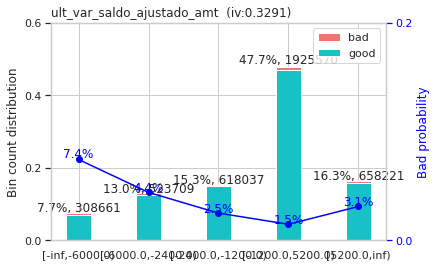

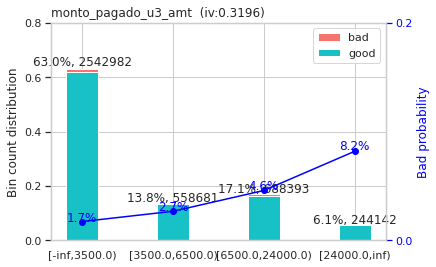

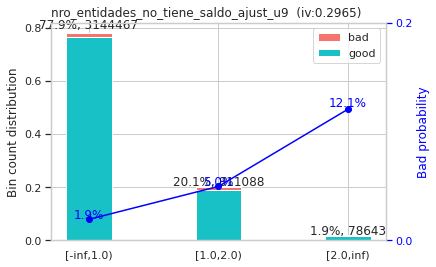

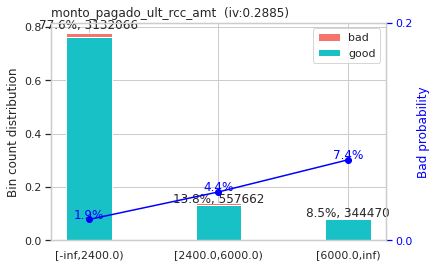

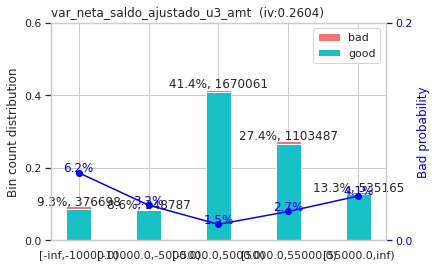

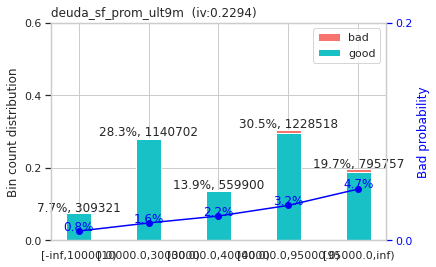

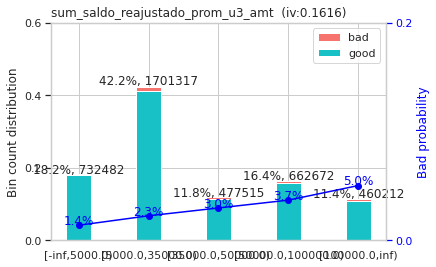

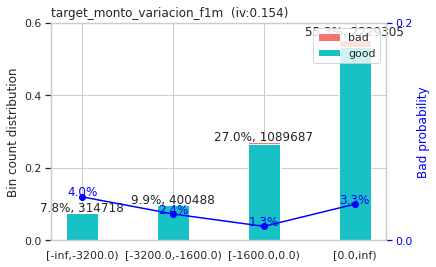

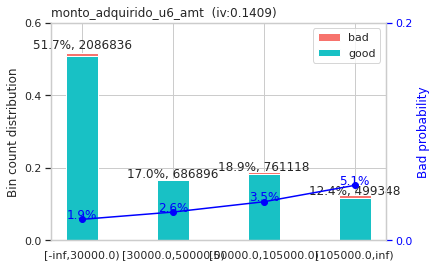

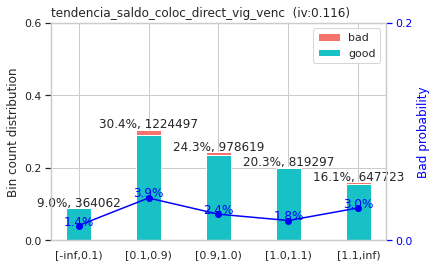

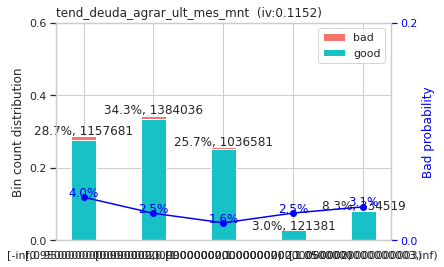

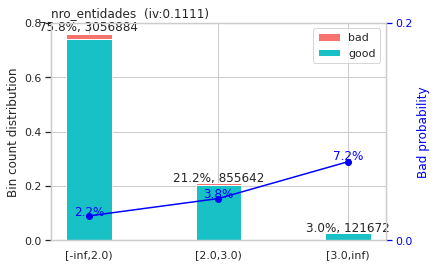

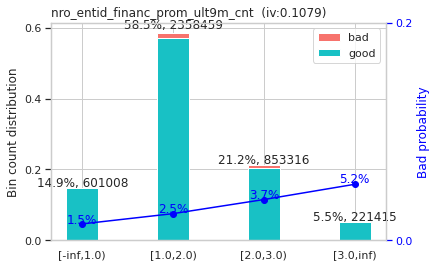

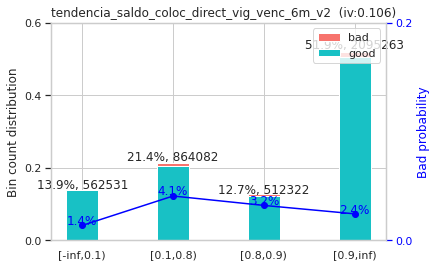

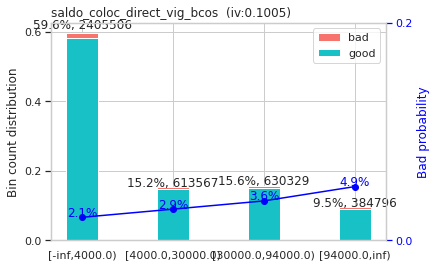

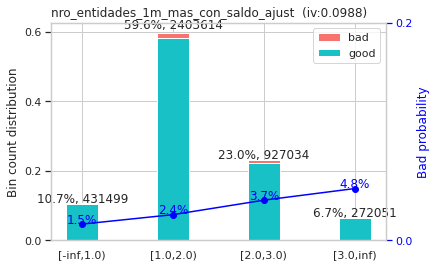

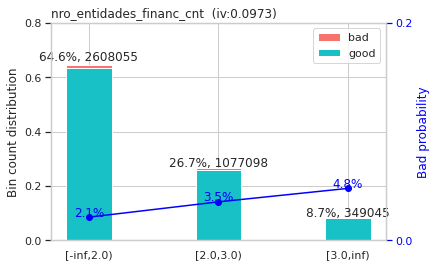

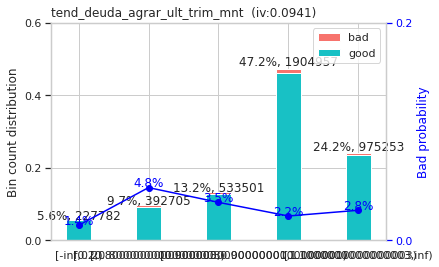

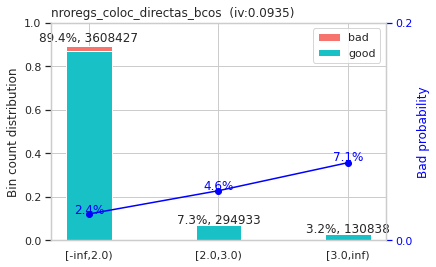

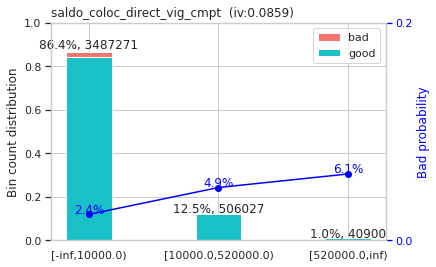

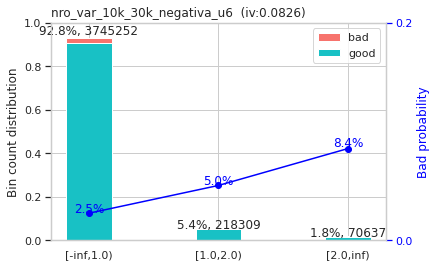

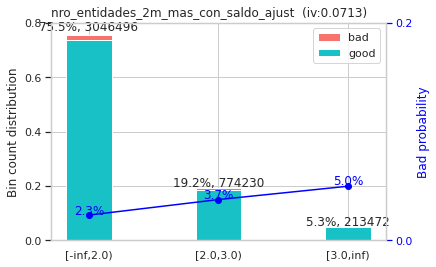

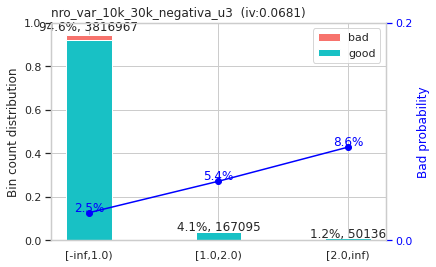

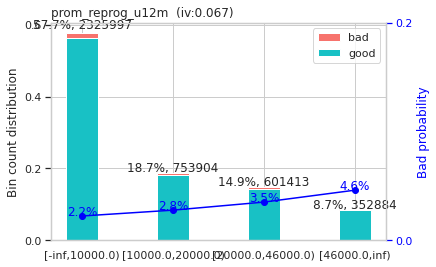

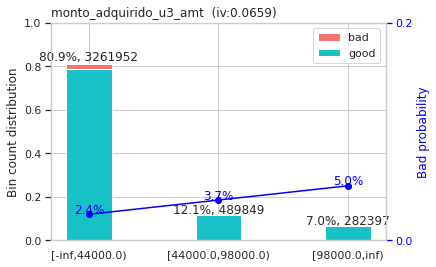

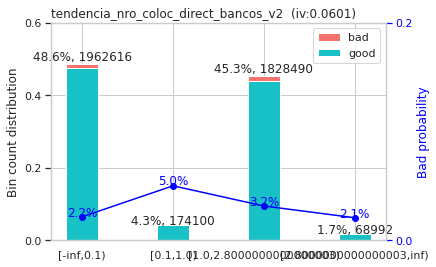

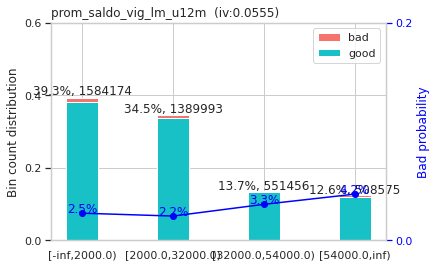

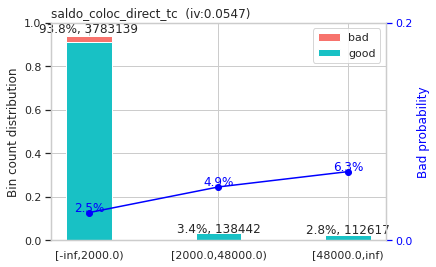

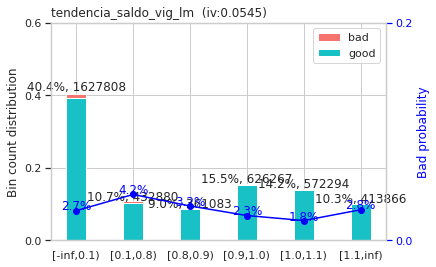

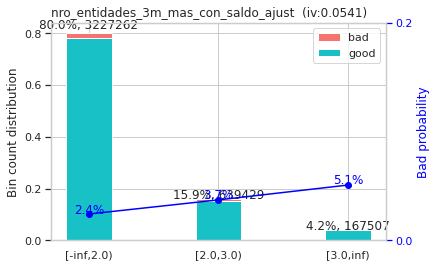

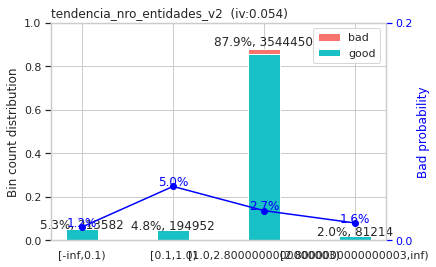

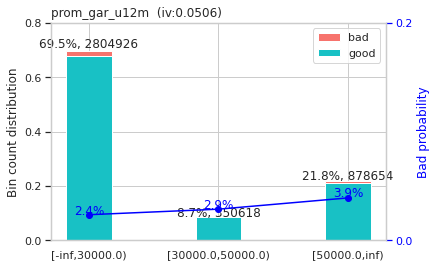

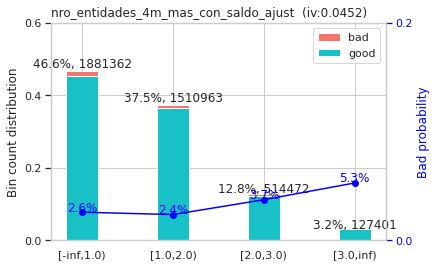

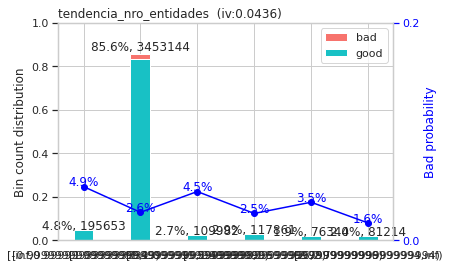

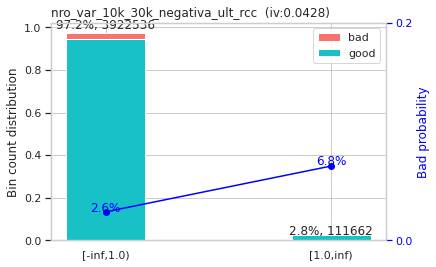

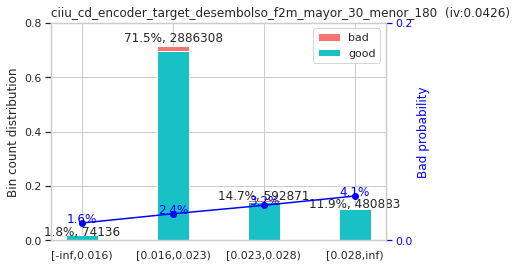

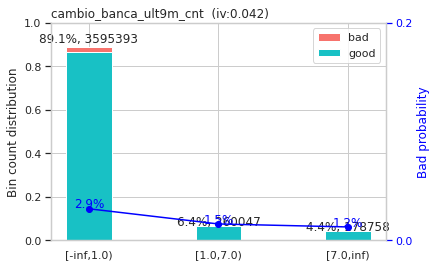

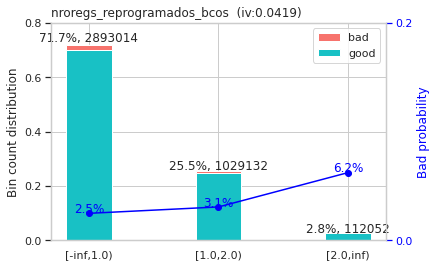

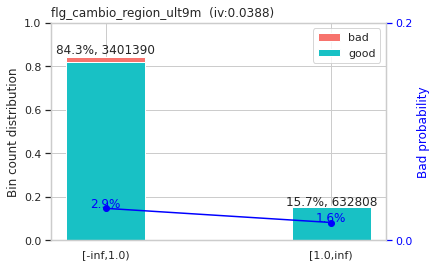

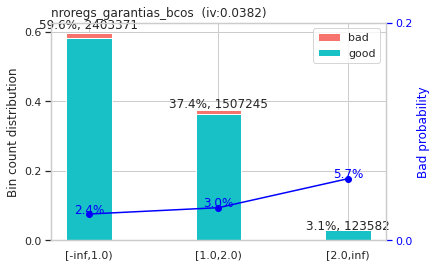

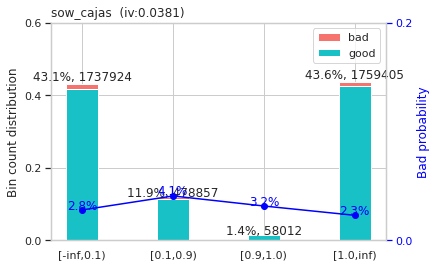

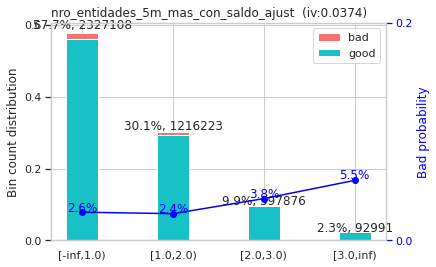

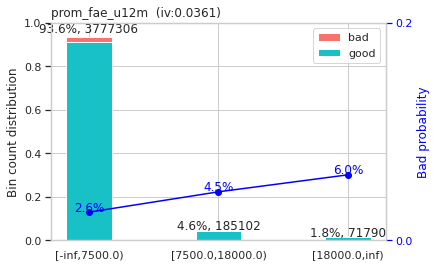

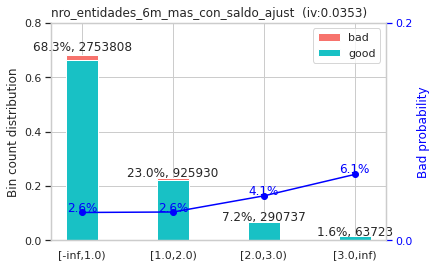

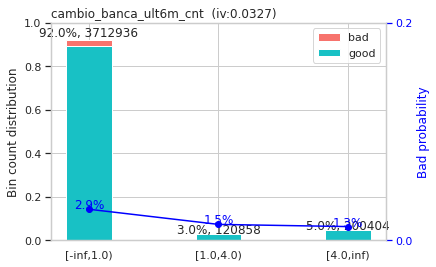

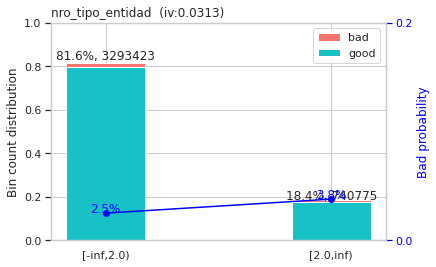

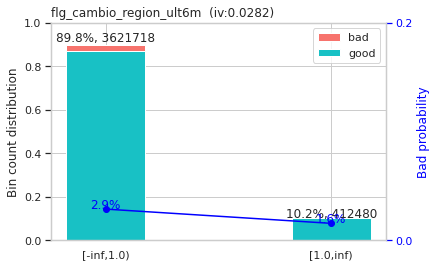

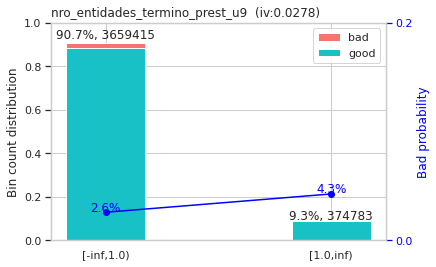

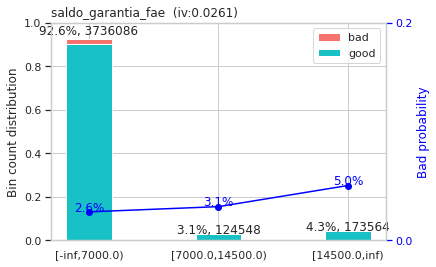

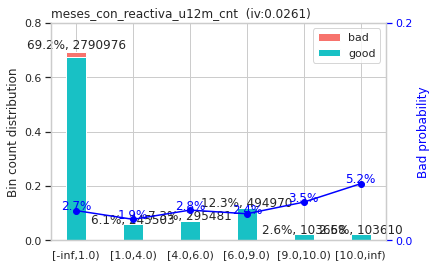

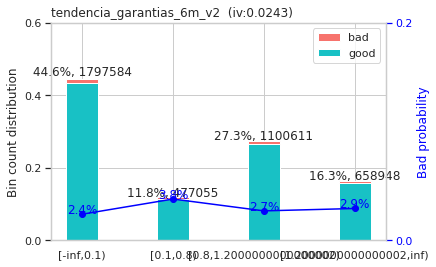

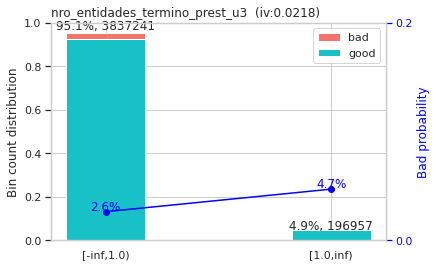

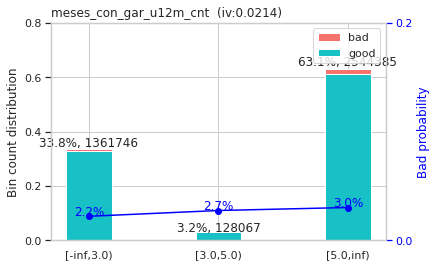

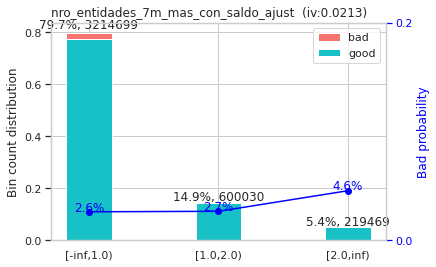

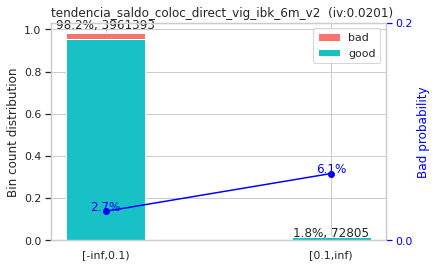

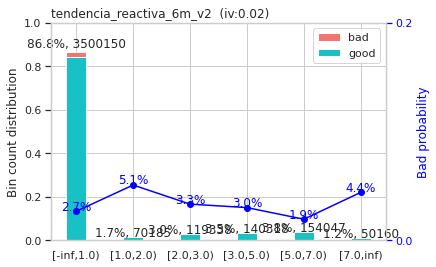

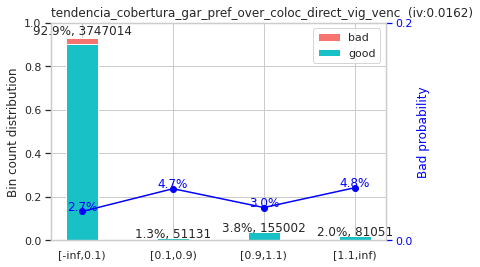

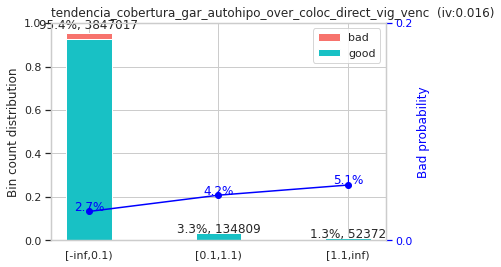

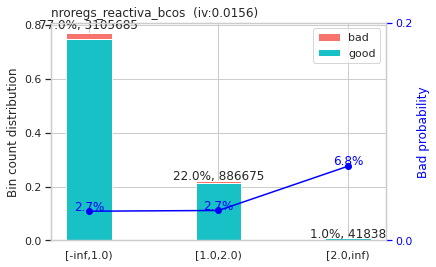

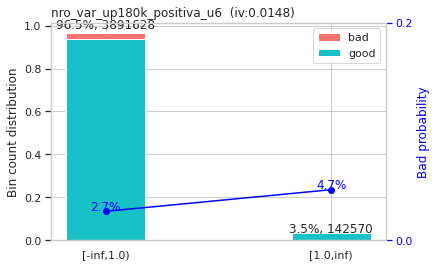

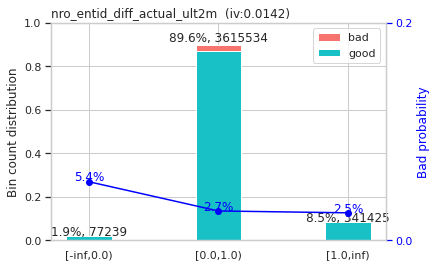

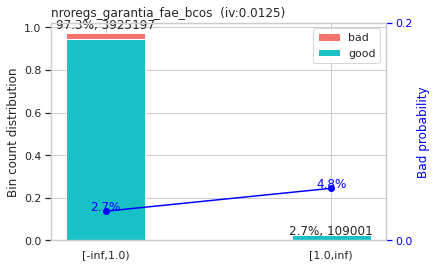

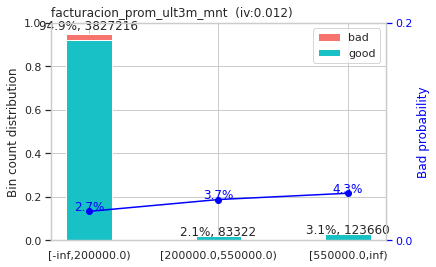

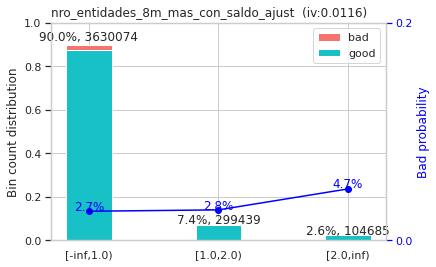

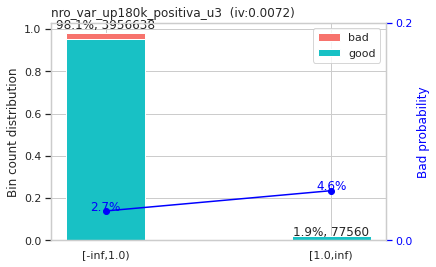

In [25]:
import scorecardpy as sc

ploteo = sc.woebin_plot(woe_dict)

In [26]:
#content_object = s3.Object('bucket', woe.split(bucket)[-1][1:])
#file_content = content_object.get()['Body'].read().decode('utf-8')
#json_content = json.loads(file_content)

In [27]:
#dupliccidad_signiicado = ['nro_entidades_ya_no_tiene_saldo_ajustado_u9m']

#descarte = [
#    'ultima_variacion_saldo_ajustado',
#    'tendencia_monto_deuda_agr_ult_mes', 'tendencia_monto_deuda_agr_utl_trim',
#    'monto_pagado_ult_rcc',  'variacion_neta_saldo_ajustado_u6m',
#  'variacion_neta_saldo_ajustado_u3m'
#]

#len(dupliccidad_signiicado), len(descarte)

In [34]:
selection = list(set([
'nroregs_reactiva_bcos',
'prom_fae_u12m',
'sow_cajas',
'prom_gar_u12m',
'saldo_coloc_direct_tc',
'tendencia_nro_coloc_direct_bancos_v2',
'prom_reprog_u12m',
'nro_var_10k_30k_negativa_u3',
'nro_var_10k_30k_negativa_u6',	
'saldo_coloc_directa_vig_cmpt',
'saldo_coloc_directa_vig_bcos',
'nro_entid_financ_prom_ult9m_cnt',
'nro_entidades',
'monto_adquirido_u6_amt',
'deuda_sf_prom_ult9m',
'var_neta_saldo_ajustado_u3_amt',
'monto_pagado_ult_rcc_amt',
'monto_pagado_u3_amt',
'ult_var_saldo_ajustado_amt'
]))

len(selection)

19

In [35]:
selection

['deuda_sf_prom_ult9m',
 'saldo_coloc_direct_tc',
 'prom_reprog_u12m',
 'ult_var_saldo_ajustado_amt',
 'nro_entid_financ_prom_ult9m_cnt',
 'monto_adquirido_u6_amt',
 'nro_var_10k_30k_negativa_u6',
 'var_neta_saldo_ajustado_u3_amt',
 'prom_gar_u12m',
 'nroregs_reactiva_bcos',
 'monto_pagado_u3_amt',
 'saldo_coloc_directa_vig_bcos',
 'saldo_coloc_directa_vig_cmpt',
 'nro_entidades',
 'monto_pagado_ult_rcc_amt',
 'tendencia_nro_coloc_direct_bancos_v2',
 'sow_cajas',
 'prom_fae_u12m',
 'nro_var_10k_30k_negativa_u3']

In [30]:
lista = ['202008', '202009', '2020010', '202011', '202012', '202101', '202102', '202103', '202104', '202105', '202106', '202107', '202108']

In [31]:
print(lista[:-5])

['202008', '202009', '2020010', '202011', '202012', '202101', '202102', '202103']


In [32]:
print(lista[-6:-3])

['202103', '202104', '202105']


In [33]:
print(lista[-3:])

['202106', '202107', '202108']
